# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.api as sms

%matplotlib inline

## Hypothesis testing

The following is a version of `thinkstats2.HypothesisTest` with just the essential methods:

In [3]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

And here's an example that uses it to compute the p-value of an experiment where we toss a coin 250 times and get 140 heads.

In [4]:
class CoinTest(HypothesisTest):

    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat

    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

The p-value turns out to be about 7%, which is considered on the border of statistical significance.

In [5]:
ct = CoinTest((140, 110))
pvalue = ct.PValue()
pvalue

0.058

In [6]:
# Mine using statsmodels
sms.proportions_ztest(140, 250, 0.5, prop_var=0.5)

(1.8973665961010293, 0.05777957112359698)

In [7]:
# Mine using the book's hypothesis test and my own defined sub-class

In [8]:
from collections import defaultdict, Counter

In [9]:
class MyCoinTest(HypothesisTest):
    
    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat
    
    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = np.random.choice(['H', 'T'], size=n)
        hist = Counter(np.random.choice(['H', 'T'], size=n))
        data = hist['H'], hist['T']
        return data

In [10]:
my_ct = MyCoinTest((140, 110))
my_ct.PValue()

0.061

## Permutation test

To compute the p-value of an observed difference in means, we can assume that there is no difference between the groups and generate simulated results by shuffling the data.

In [11]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

Here's an example where we test the observed difference in pregnancy length for first babies and others.

In [12]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

The p-value is about 17%, which means it is plausible that the observed difference is just the result of random sampling, and might not be generally true in the population.

In [13]:
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.161

In [14]:
# Mine, statsmodels gives the same result
sms.ttest_ind(firsts.prglngth.values, others.prglngth.values)

(1.3802152088125645, 0.1675541263941503, 9146.0)

Here's the distrubution of the test statistic (the difference in means) over many simulated samples:

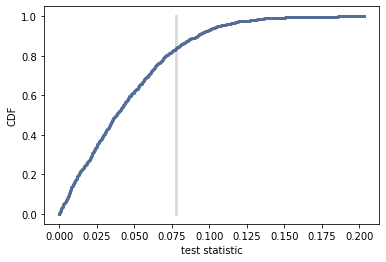

In [15]:
ht.PlotCdf()
thinkplot.Config(xlabel='test statistic',
                   ylabel='CDF')

In [16]:
# Mine using my own version of the book's hypothesis test class and my own sub class
class MyHypothesisTest(object):
    """Represents a hypothesis test. 
    The actual test statistic for the data is available through a .actual attribute. 
    After PValue is run the scipy stats random variable for the sampling distribution is available through a .rv attribute. 
    The cdf of the distribution along with a line representing the test statistic value can be plotted using PlotCdf(). 
    The largest test statistic seen in the simulations is given by MaxTestStat()."""

    def __init__(self, data):
        """Initializes.

        data: data in whatever form is relevant
        """
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)
        self.test_stats = None
        self.rv = None

    def PValue(self, iters=1000):
        """Computes the distribution of the test statistic and p-value.

        iters: number of iterations

        returns: float p-value
        """
        self.test_stats = [self.TestStatistic(self.RunModel())
                           for _ in range(iters)]
        self.rv = DiscreteRv(self.test_stats)

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def MaxTestStat(self):
        """Returns the largest test statistic seen during simulations.
        """
        return max(self.test_stats)

    def PlotCdf(self, label=None):
        """Draws a Cdf with vertical lines at the observed test stat.
        """      
        def VertLine(x):
            """Draws a vertical line at x."""
            plt.plot([x, x], [0, 1], color='0.8')

        VertLine(self.actual)
        plt.plot(self.rv.xk, self.rv.cdf(self.rv.xk))

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        raise UnimplementedMethodException()

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        pass

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        raise UnimplementedMethodException()

In [17]:
t_pool = np.hstack((firsts.prglngth.values, others.prglngth.values))
t_n = len(firsts.prglngth.values)

In [18]:
def TRunModel(t_pool=t_pool, t_n=t_n):
    np.random.shuffle(t_pool)
    data = t_pool[:t_n], t_pool[t_n:]
    return data

In [19]:
def TTestStatistic(data):
    group1, group2 = data
    test_stat = abs(group1.mean() - group2.mean())
    return test_stat

In [20]:
t_test_stats = [TTestStatistic(TRunModel()) for _ in range(1000)]
t_test_stats

[0.04476473584931995,
 0.03360083041584261,
 0.021342529547553113,
 0.027033883522122437,
 0.007114240325279297,
 0.02221812246671817,
 0.0541772640161966,
 0.027471679981701413,
 0.036446603117262555,
 0.008865426163602308,
 0.06950014010156735,
 0.032287441037098574,
 0.007770839300512478,
 0.04870490398556626,
 0.02112372703189891,
 0.016526768492155952,
 0.1029916649737217,
 0.006019653462182362,
 0.04082456771308074,
 0.11787674459950637,
 0.0355710101980975,
 0.01981033765314777,
 0.017621355355245782,
 0.025939488087303175,
 0.025939488087303175,
 0.027690673925626186,
 0.05220727566221228,
 0.07956945867195486,
 0.131448434846547,
 0.04345134647057591,
 0.02790947644128039,
 0.01981033765314777,
 0.02287491287022192,
 0.06337098966742616,
 0.01477558265381873,
 0.12575708087198478,
 0.023531511845462205,
 0.0009850898911309969,
 0.09357894537857447,
 0.025720494143371297,
 0.013462193275081802,
 0.047172520662883244,
 0.06753015174759014,
 0.0005472934315449152,
 0.012805594299

In [21]:
# Now need to try to replicate this result myself with my own methods and subsitute that into the hypothesis class
thinkstats2.Cdf(t_test_stats)

Cdf([1.09496972e-04 3.28299488e-04 5.47293432e-04 7.66095947e-04
 9.85089891e-04 1.20389241e-03 1.42288635e-03 1.64168887e-03
 1.86068281e-03 2.07948533e-03 2.51728179e-03 2.73627573e-03
 2.95507825e-03 3.17407219e-03 3.39287470e-03 3.61186865e-03
 3.83067116e-03 4.04966511e-03 4.48746157e-03 4.70626408e-03
 4.92525803e-03 5.14406054e-03 5.36305449e-03 5.58185700e-03
 5.80085095e-03 6.01965346e-03 6.23864741e-03 6.67644387e-03
 6.89524638e-03 7.11424033e-03 7.33304284e-03 7.55203678e-03
 7.77083930e-03 7.98983324e-03 8.20863576e-03 8.42762970e-03
 8.64643222e-03 8.86542616e-03 9.08422868e-03 9.30322262e-03
 9.52202514e-03 9.74101908e-03 9.95982160e-03 1.01788155e-02
 1.03976181e-02 1.06166120e-02 1.08354145e-02 1.10544085e-02
 1.12732110e-02 1.17110074e-02 1.19300014e-02 1.21488039e-02
 1.23677978e-02 1.25866004e-02 1.28055943e-02 1.30243968e-02
 1.32433908e-02 1.34621933e-02 1.36811872e-02 1.38999897e-02
 1.41189837e-02 1.43377862e-02 1.45567801e-02 1.47755827e-02
 1.49945766e-02 1.52

In [22]:
def DiscreteRv(a):
    """Creates a scipy.stats discrete_rv.

    Arguments:
        a {array-like} -- a single data set, will be flattened if it is not already 1-D

    Returns:
        An instance of scipy.stats discrete_rv representing the input data
    """
    val,cnt = np.unique(a, return_counts=True)
    
    return stats.rv_discrete(values=(val,cnt/sum(cnt)))

In [23]:
class MyDiffMeansPermute(MyHypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [24]:
my_ht = MyDiffMeansPermute(data)
my_pvalue = my_ht.PValue()
my_pvalue

0.168

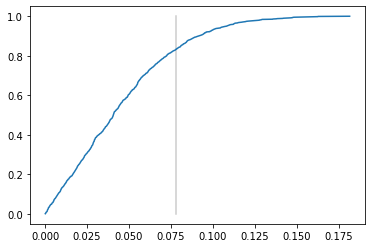

In [25]:
my_ht.PlotCdf()

In [26]:
my_ht.rv

Under the null hypothesis, we often see differences bigger than the observed difference.

In [27]:
ht.actual

0.07803726677754952

In [28]:
class DiffMeansOneSided(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

If the hypothesis under test is that first babies come late, the appropriate test statistic is the raw difference between first babies and others, rather than the absolute value of the difference.  In that case, the p-value is smaller, because we are testing a more specific hypothesis.

In [29]:
ht = DiffMeansOneSided(data)
pvalue = ht.PValue()
pvalue

0.088

In [30]:
# Mine, statsmodels gives a somewhat different but comparable result using the one-sided larger hypothesis
sms.ttest_ind(firsts.prglngth.values, others.prglngth.values, alternative='larger', value = 0)

(1.3802152088125645, 0.08377706319707515, 9146.0)

But in this example, the result is still not statistically significant.

In [31]:
# Work on building a function to calculate this computationally
# Already built one of these earlier but did not include it my module, I think because I found the statsmodels functions
# One I already built is below
def PermuteDiffMean(data1, data2, absvalue = False, iters=100):
    """Uses sampling with replacement to generate a sampling distribution of mean for a variable.
    Can then make an rv of the distributions to plot cdf, compute p-value of the mean under null hypothesis (eg. rv.cdf at 0), 
    and calculate sample distribution mean, std deviation (std error), and confidence interval (rv.interval).

    Args:
        data (array-like): Data for the variable of interest
        weights (array-like, optional): Can include weights for the data. Used as DataFrame.sample parameter. Defaults to None.
        iters (int, optional): The number of resampling iterations. Defaults to 100.

    Returns:
        mean_estimates (list): A mean estimates sampling distribution
    """
    s1 = pd.Series(data1)
    s2 = pd.Series(data2)
    n = len(s1)
    s_concat = pd.concat([s1, s2])
    
    diff_means = []
    for _ in range(iters):
        s_shuffled = s_concat.sample(frac=1)
        s1_new, s2_new = s_shuffled[:n], s_shuffled[n:]
        if absvalue:
            diff_mean = abs(s1_new.mean() - s2_new.mean())
        else:
            diff_mean = s1_new.mean() - s2_new.mean()
        diff_means.append(diff_mean)
    
    return diff_means

In [32]:
diff_means = PermuteDiffMean(firsts.prglngth.values, others.prglngth.values, iters=1000)

In [33]:
np.mean(diff_means)

0.002674546428654125

In [34]:
def DiscreteRv(a):
    """Creates a scipy.stats discrete_rv.

    Arguments:
        a {array-like} -- a single data set, will be flattened if it is not already 1-D

    Returns:
        An instance of scipy.stats discrete_rv representing the input data
    """
    val,cnt = np.unique(a, return_counts=True)
    
    return stats.rv_discrete(values=(val,cnt/sum(cnt)))

In [35]:
diff_means_rv = DiscreteRv(diff_means)

In [36]:
# This is for the case of using absolute value of difference of mean in PermuteDiffMean function
# Need to learn more about not using absolute value and how that relates to one vs two tailed tests for this
(1 - diff_means_rv.cdf(ht.actual))

0.0849999999999993

In [37]:
# Save this one to my module
# Remove the seed parameter and print statements before saving to module
def DiffMeansRandomization(a, b, iters=1000, onesided=False, seed=123):
    """Generates a list of differences in means of two data sets from randomized simulations.
       Can then use the 'max' built-in to find what the most extreme value is.

    Args:
        a (array-like): Input data set 1
        b (array-like): Input data set 2
        iters (int, optional): The number of simulations to run (Defaults to 1000)
        onesided (bool): If set to True a onesided test is run, not using absolute value of difference (defaults to False) 

    Returns:
        list: The differences in means from the simulations
    """
    # set seed
    np.random.seed(seed)
        
    # Combine the two data sets
    a_size = len(a)
    pooled_data = np.hstack((a, b))

    # Calculate the difference in means of randomized samples from the pooled data
    diff_mean_results = []
    
    if onesided == False:
        for _ in range(iters):
            np.random.shuffle(pooled_data)
            group1 = pooled_data[:a_size]
            group2 = pooled_data[a_size:]
            result = abs(group1.mean() - group2.mean())
            diff_mean_results.append(result)
        print(1)
    
    elif onesided == True:
        for _ in range(iters):
            np.random.shuffle(pooled_data)
            group1 = pooled_data[:a_size]
            group2 = pooled_data[a_size:]
            result = group1.mean() - group2.mean()
            diff_mean_results.append(result)
        print(2)
    
    else:
        raise TypeError('\'onesided\' parameter only accepts Boolean True or False')
    
    return diff_mean_results

In [38]:
diff_means_results = DiffMeansRandomization(firsts.prglngth.values, others.prglngth.values, iters=1000, onesided=True)

2


In [39]:
diff_means_rv2 = DiscreteRv(diff_means_results)
(1 - diff_means_rv2.cdf(ht.actual))

0.0909999999999993

In [40]:
# Make a GeneratePvalue function that gives left tail (probability of value less than test_statistic) or right tail value
# Finish and test this function, add error message
def GeneratePvalue(estimates, test_statistic, tail='left'):
    rv = DiscreteRv(estimates)
    
    if tail == 'left':
        pvalue = rv.cdf(test_statistic)
    elif tail == 'right':
        pvalue = 1 - rv.cdf(test_statistic)
    else:
        raise Exception('The value of \'tail\' can only be either \'left\' or \'right\'')
    
    return pvalue

In [41]:
GeneratePvalue(diff_means_results, ht.actual, tail='right')

0.0909999999999993

## Difference in standard deviation

In this framework, it is easy to use other test statistics.  For example, if we think the variance for first babies might be higher, we can run this test:

In [42]:
class DiffStdPermute(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

In [43]:
ht = DiffStdPermute(data)
pvalue = ht.PValue()
pvalue

0.075

But that's not statistically significant either.

## Testing correlation

To check whether an observed correlation is statistically significant, we can run a permutation test with a different test statistic.

In [44]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

Here's an example testing the correlation between birth weight and mother's age.

In [45]:
cleaned = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = cleaned.agepreg.values, cleaned.totalwgt_lb.values
ht = CorrelationPermute(data)
pvalue = ht.PValue()
pvalue

0.0

The reported p-value is 0, which means that in 1000 trials we didn't see a correlation, under the null hypothesis, that exceeded the observed correlation.  That means that the p-value is probably smaller than $1/1000$, but it is not actually 0.

To get a sense of how unexpected the observed value is under the null hypothesis, we can compare the actual correlation to the largest value we saw in the simulations.

In [46]:
ht.actual, ht.MaxTestStat()

(0.06883397035410907, 0.033457776238198)

In [47]:
# Mine, also gives a very low p value close to zero, and same value for r too
stats.pearsonr(cleaned.agepreg.values, cleaned.totalwgt_lb.values)

(0.0688339703541091, 5.722947107252811e-11)

In [48]:
class MyCorrelationPermute(MyHypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(stats.pearsonr(xs, ys)[0])
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [49]:
my_corr_ht = MyCorrelationPermute(data)
my_corr_pvalue = my_corr_ht.PValue()
my_corr_pvalue

0.0

In [50]:
stats.pearsonr(cleaned.agepreg.values, cleaned.totalwgt_lb.values)

(0.0688339703541091, 5.722947107252811e-11)

In [51]:
my_corr_ht.actual, my_corr_ht.MaxTestStat()

(0.0688339703541091, 0.03325348720629023)

## Testing proportions

Here's an example that tests whether the outcome of a rolling a six-sided die is suspicious, where the test statistic is the total absolute difference between the observed outcomes and the expected long-term averages.

In [52]:
class DiceTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def RunModel(self):
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

Here's an example using the data from the book:

In [53]:
data = [8, 9, 19, 5, 8, 11]
dt = DiceTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.127

The observed deviance from the expected values is not statistically significant.

By convention, it is more common to test data like this using the chi-squared statistic:

In [54]:
class DiceChiTest(DiceTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

Using this test, we get a smaller p-value:

In [55]:
dt = DiceChiTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.0408

Taking this result at face value, we might consider the data statistically significant, but considering the results of both tests, I would not draw any strong conclusions.

In [56]:
# Mine, using scipy stats method
exp = [10, 10, 10, 10, 10, 10]
obs = [8, 9, 19, 5, 8, 11]
stats.chisquare(obs, exp)

Power_divergenceResult(statistic=11.6, pvalue=0.040699388504049985)

In [57]:
# Make a general chisquared hypothesis test, using precalculated observed and expected values
# If this gives identical values to scipy.stats then don't really need a separate class at all
# Need to finish RunModel below and test it but this is difficult because of the 'values' used below
# I think what I need to generalize this is to use the unique expected values and weight them
# For example with my use of evaluation grades, each grade has a different discernable weight for it eg. GD 60%, VG 25%, etc.
# Still need to get the frequencies of the hist value to bet model_observed
# Test this class using an example of my evaluation grade thing
class MyChiSquaredTest(MyHypothesisTest):
    '''Represents a hypothesis test for two sequences, observed and expected. 
    The sequences must be the same length, be integer counts of a categorical variable 
    and have the same number of total values. 
    If the number of total values is different, first normalize the expected values 
    and then create a new expected values sequence by multiplying by the total number of observed values. 
    adjust_expected = expected/sum(expected)*sum(observed)'''
    
    def TestStatistic(self, data):
        observed, expected = data
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

    def RunModel(self):
        observed, expected = self.data
        n = sum(observed)
        values = list(range(len(expected)))
        p_exp = expected/sum(expected)
        hist = Counter({x:0 for x in values}) # Initiatlize a Counter with zero values
        hist.update(np.random.choice(values, size=n, replace=True, p=p_exp))
        sorted_hist = sorted(hist.items())
        model_observed = np.array([x[1] for x in sorted_hist])
        return model_observed, expected

In [58]:
my_obs=np.array([25,32,67,20])
my_exp=np.array([12,22,33,7])
my_data= np.array(my_obs), np.array(my_exp)
my_chi = MyChiSquaredTest(my_data)

In [59]:
# This one doesn't match the pvalue from scipy stats because the number of values in expected and observed are different
# Using this class requires that the value totals be equal and I mention this in the docstring.
my_chi.PValue()

0.106

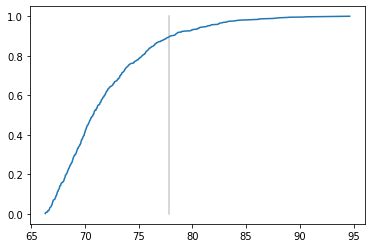

In [60]:
my_chi.PlotCdf()

In [61]:
my_chi.actual

77.80194805194805

In [62]:
# Try with stats chisquare
stats.chisquare([25,32,67,20],[12,22,33,7])

Power_divergenceResult(statistic=77.80194805194805, pvalue=9.087305900816393e-17)

In [63]:
# To test with case of adjusted expected values
my_adjusted_exp = my_exp/sum(my_exp)*sum(my_obs)
my_adjusted_exp

array([23.35135135, 42.81081081, 64.21621622, 13.62162162])

In [64]:
my_adj_data= np.array(my_obs), np.array(my_adjusted_exp)
my_adj_chi = MyChiSquaredTest(my_adj_data)
my_adj_chi.PValue()

0.101

In [65]:
my_adj_chi.actual

5.95377886002886

In [66]:
# Try adjusted with stats chisquare
# OK this is working
# Mine actually is able to make adjustments like this on its own, but not in the test statistic
# Just keep this as is, requiring equal numbers of values and setting this up beforehand if needed, as described in docstring
stats.chisquare([25,32,67,20],my_adjusted_exp)

Power_divergenceResult(statistic=5.95377886002886, pvalue=0.11388076657337906)

## Chi-square test of pregnancy length

In [67]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

If we specifically test the deviations of first babies and others from the expected number of births in each week of pregnancy, the results are statistically significant with a very small p-value.  But at this point we have run so many tests, we should not be surprised to find at least one that seems significant.

In [68]:
data = firsts.prglngth.values, others.prglngth.values
ht = PregLengthTest(data)
p_value = ht.PValue()
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

p-value = 0.0
actual = 101.50141482893264
ts max = 25.855819570946977


In [69]:
type(data)

tuple

In [70]:
# Did this already in the My practice - cut and hist plots, hypothesis testing (chap9) notebook

In [71]:
# Make my own generalized Chisquared class, change self.values to generalized rv.xk below before saving
# Incomplete, stopped working on this because I do not think I would use this test in this kind of situation
# If I want to complete this at some point I would need to finish the ChiSquared function below using Counter
class MyChiSquaredTest(MyHypothesisTest):
    '''Takes a tuple of data'''

    def MakeModel(self):
        observed, expected = self.data

    def RunModel(self):
        n=1000
        values = [x for x in range(len(expected))]
        p = expected/expected.sum()
        hist = Counter(np.random.choice(values, size=n, replace=True, p=p))
        sorted_hist = sorted(hist.items())
        model_observed = [x[1]/n for x in sorted_hist]
        return data
    
    def TestStatistic(self, data):
        observed, expected = data
        stat = self.ChiSquared(group1) + self.ChiSquared(group2)
        return stat

    def ChiSquared(self, data):
        hist = Counter(data)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

## Power

Here's the function that estimates the probability of a non-significant p-value even is there really is a difference between the groups.

In [72]:
def FalseNegRate(data, num_runs=1000):
    """Computes the chance of a false negative based on resampling.

    data: pair of sequences
    num_runs: how many experiments to simulate

    returns: float false negative rate
    """
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.PValue(iters=101)
        if p_value > 0.05:
            count += 1

    return count / num_runs

In [73]:
neg_rate = FalseNegRate(data)
neg_rate

0.711

In this example, the false negative rate is 70%, which means that the power of the test (probability of statistical significance if the actual difference is 0.078 weeks) is only 30%.

## Exercises

**Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [74]:
# Solution goes here
# I will use the cleaned DataFrame and correlation between age (agepreg) and birthweight (totalwgt_lb)
cleaned

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875
5,6,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,4870.926435,5325.196999,8874.440799,1,23,NaN,8.5625
6,6,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,4870.926435,5325.196999,8874.440799,1,23,NaN,9.5625
7,6,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,4870.926435,5325.196999,8874.440799,1,23,NaN,8.3750
8,7,1,NaN,NaN,NaN,NaN,5.0,NaN,1.0,NaN,...,0,0,0,3409.579565,3787.539000,6911.879921,2,14,NaN,7.5625
9,7,2,NaN,NaN,NaN,NaN,5.0,NaN,1.0,NaN,...,0,0,0,3409.579565,3787.539000,6911.879921,2,14,NaN,6.6250


In [75]:
# Solution goes here
# First with full samples
stats.pearsonr(cleaned.agepreg.values, cleaned.totalwgt_lb.values)

(0.0688339703541091, 5.722947107252811e-11)

In [76]:
cleaned_1000 = cleaned.sample(n=1000)
stats.pearsonr(cleaned_1000.agepreg.values, cleaned_1000.totalwgt_lb.values)

(0.10123523366642087, 0.001347935165073089)

In [77]:
# No longer significant at this point
cleaned_100 = cleaned.sample(n=100)
stats.pearsonr(cleaned_100.agepreg.values, cleaned_100.totalwgt_lb.values)

(-0.06346681128747177, 0.5304484007602066)

In [78]:
# Solution goes here

**Exercise:** In Section 9.3, we simulated the null hypothesis by permutation; that is, we treated the observed values as if they represented the entire population, and randomly assigned the members of the population to the two groups.

An alternative is to use the sample to estimate the distribution for the population, then draw a random sample from that distribution. This process is called resampling. There are several ways to implement resampling, but one of the simplest is to draw a sample with replacement from the observed values, as in Section 9.10.

Write a class named `DiffMeansResample` that inherits from `DiffMeansPermute` and overrides `RunModel` to implement resampling, rather than permutation.

Use this model to test the differences in pregnancy length and birth weight. How much does the model affect the results?

In [84]:
class DiffMeansRandom(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        sample_pool = np.random.choice(self.pool, size=self.n+self.m, replace=True)
        data = sample_pool[:self.n], sample_pool[self.n:]
        return data

In [86]:
# Yields a similar pvalue
exer_data = firsts.prglngth.values, others.prglngth.values
ht = DiffMeansRandom(exer_data)
pvalue = ht.PValue()
pvalue

0.163

In [51]:
# Solution goes here